In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sy
from torch import nn
import torch

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

# L06

In this notebook I will experiment with function approximation with a feedforward nural network. I have done two experiments: (a) the effects of taking the gradient into account with calculating the loss, (b) Active learning stadegies to minimize the number of points evaluated.

## E14.X01

In this experiment I will try to approximate the two function: $f(x)= sin(x)$ and $f(x) = exp(sin(x))$, with a neural network. Two different stadegies for the loss function will be tried: (a) MSE loss between the predicted and true function values, (b) MSE loss between the predicted and true function values plus the MSE loss between the predicted gradients and true gradients of the function.

The two function are plotted below:

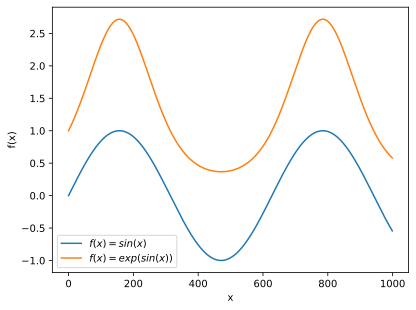

In [2]:
xs = torch.linspace(0,10,1000)[:,None]
ys_1 = torch.sin(xs)
ys_2 = torch.exp(torch.sin(xs))

plt.plot(ys_1, label="$f(x)=sin(x)$")
plt.plot(ys_2, label="$f(x)=exp(sin(x))$")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()


### $sin(x)$

Below I have defined the feed forward nural network I will be using for both functions. I will be using SGD to optimize the function values with and without the gradient information. I will be using information in the range 0-10 along 1000 linear spaced points.

In [3]:
class FF(nn.Module):
    def __init__(self):
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(1,100),
            nn.Tanh(),
            nn.Linear(100,100),
            nn.Tanh(),
            nn.Linear(100,1),
        )

    def forward(self,x):
        return self.ff(x)

#### Without gradient

In [4]:
model_sin = FF()
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model_sin.parameters(), lr=0.01)
losses_sin = []

xs = torch.linspace(0,10,1000)[:,None]
ys = torch.sin(xs)

epochs = 10_000
for i in range(epochs):

    pred = model_sin(xs)
    loss = loss_fn(pred, ys)
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses_sin.append(float(loss))

#### With gradient

In [5]:
model_sin_grad = FF()
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model_sin_grad.parameters(), lr=0.01)
losses_sin_grad = []

xs = torch.linspace(0,10,1000)[:,None]
ys = torch.sin(xs)
dy_dx = torch.cos(xs)

epochs = 10_000
for i in range(epochs):

    xs_grad = torch.asarray(xs, requires_grad=True)

    pred = model_sin_grad(xs_grad)
    # By chatGPT:
    pred_gradients = torch.autograd.grad(outputs=pred, inputs=xs, grad_outputs=torch.ones_like(pred), create_graph=True)[0]
    
    loss = loss_fn(pred, ys) + loss_fn(pred_gradients, dy_dx)
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses_sin_grad.append(float(loss))

#### Results

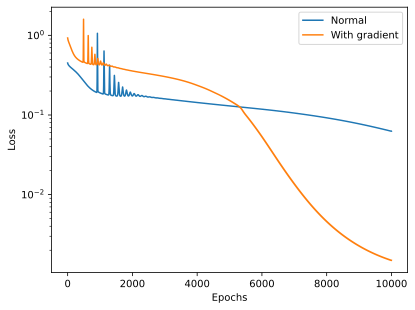

In [6]:
plt.semilogy(losses_sin, label="Normal")
plt.semilogy(losses_sin_grad, label="With gradient")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

After 10000 epochs the loss function indicates that the + gradient method is better at learning since its curve is decreasing more.

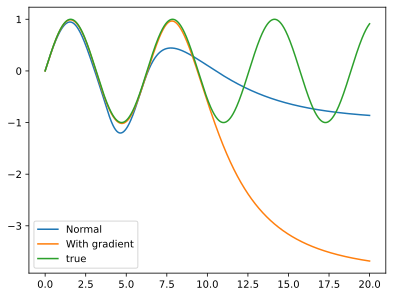

In [7]:
xs = torch.linspace(0,20,1000)[:,None]
ys = torch.sin(xs)

plt.plot(xs, model_sin(xs).detach(), label="Normal")
plt.plot(xs, model_sin_grad(xs).detach(), label="With gradient")
plt.plot(xs, ys, label="true")
plt.legend()

From the plot above it can be seen that the model with the gradient information is better at predicting the true values of the function. After 10 both models is seen to fail since they begin to extrapolate outside the data that has been given to them.

### $exp(sin(x))$

I will now do the exact same experiment as above but using $f(x) = exp(sin(x))$:

#### Without gradient

In [8]:
model_exp_sin = FF()
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model_exp_sin.parameters(), lr=0.01)
losses_exp_sin = []

xs = torch.linspace(0,10,1000)[:,None]
ys = torch.exp(torch.sin(xs))

epochs = 10000
for i in range(epochs):

    pred = model_exp_sin(xs)
    loss = loss_fn(pred, ys)
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses_exp_sin.append(float(loss))

#### With gradient

In [9]:
model_exp_sin_grad = FF()
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model_exp_sin_grad.parameters(), lr=0.01)
losses_exp_sin_grad = []

xs = torch.linspace(0,10,1000)[:,None]
ys = torch.exp(torch.sin(xs))
dy_dx = torch.exp(torch.sin(xs))*torch.cos(xs)

epochs = 10000
for i in range(epochs):

    xs_grad = torch.asarray(xs, requires_grad=True)

    pred = model_exp_sin_grad(xs_grad)
    # By chatGPT:
    pred_gradients = torch.autograd.grad(outputs=pred, inputs=xs, grad_outputs=torch.ones_like(pred), create_graph=True)[0]
    
    loss = loss_fn(pred, ys) + loss_fn(pred_gradients, dy_dx)
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses_exp_sin_grad.append(float(loss))

#### Results

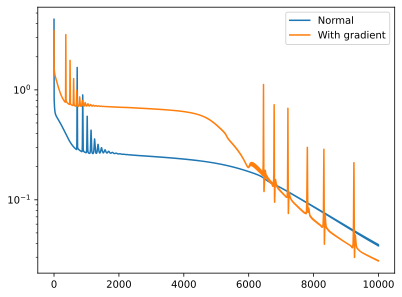

In [10]:
plt.semilogy(losses_exp_sin, label="Normal")
plt.semilogy(losses_exp_sin_grad, label="With gradient")
plt.legend()

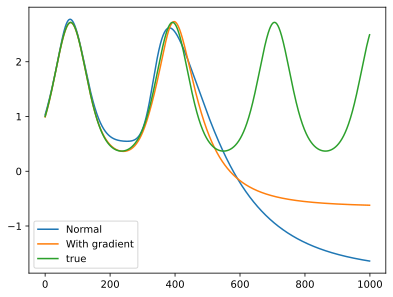

In [11]:
xs = torch.linspace(0,20,1000)[:,None]
ys = torch.exp(torch.sin(xs))

plt.plot(model_exp_sin(xs).detach(), label="Normal")
plt.plot(model_exp_sin_grad(xs).detach(), label="With gradient")
plt.plot(ys, label="true")
plt.legend()

From the plots above i can conclude that including the gradient improves the function approximation for a nural network. For both functions the results with the gradient are significantly better.

## E14.X06

In this experiment I have tried to approximate the function $f(x,y) = (|0.5-x^4-y^4| + 0.1)^{-1}$ with a nural network.
The idea is to estimate the error of the nural network by subtracting the current model with a previous model. New points are now sampled from the places where the models differ most since this is the area where most learning is happening.

Each of the methods below starts of by estimating a model based on 500 points in $(x,y) \in [0,1]^2$. The goal is to you the least number of function evaluations to approximate the true values.

I have tried to do this with a couple of different methods for adaptive sampling, they include:
- 1. Attempt: Use 500 random points to estimate the error. For every 1000 epoch: Choose 10 points weighed by the softmax function over the errors above a certain quantile. These 10 are the new points to optimize over. (Optionaly use the gradient information like above)
- 2. Attempt: Use 500 random points to estimate the error. For every 50 epoch: Choose 1 point weighed by the softmax function over the errors. Add this point to the set and remove the point with the least error.
- 3. Attempt: Use 12000 random points to estimate the error. Add the 2 points with the most error and remove 1 with the least error.

All of these methods does not approximate the function well enough to get the error below $10^{-6}$. I theorize that this is because these adaptive methods is not able to find the peaks of the function with enough points to accurately approximate it.

I get the best results with the 3. attempt with a mean error of: 0.0013.

### 1. Attempt 

In [12]:
from sympy.utilities.lambdify import lambdify
x, y = sy.var("x y")

eq = (sy.sqrt((0.5 - x**4 - y**4)**2) + 0.1)**-1
eq_diff = [sy.diff(eq,x), sy.diff(eq,y)]

f = lambdify([x,y], eq)
f_diff = lambdify([x,y], eq_diff)

Text(0.5, 0.92, 'f(x,y)')

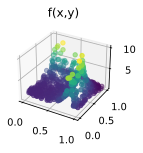

In [13]:
xy = torch.rand((500,2))
zs = f(xy[:,0], xy[:,1])
zs_diff = f_diff(xy[:,0], xy[:,1])

fig = plt.figure()

ax_1 = fig.add_subplot(1,3,1,projection='3d')
ax_1.scatter(xy[:,0], xy[:,1], zs, c=zs)
ax_1.set_title("f(x,y)")
# ax_2 = fig.add_subplot(1,3,2,projection='3d')
# ax_2.scatter(xy[:,0], xy[:,1], zs_diff[0], c=zs_diff[0])
# ax_2.set_title("f(x,y) diff x")

# ax_3 = fig.add_subplot(1,3,3,projection='3d')
# ax_3.scatter(xy[:,0], xy[:,1], zs_diff[1], c=zs_diff[1])
# ax_3.set_title("f(x,y) diff y")

In [14]:
hidden_size = 100

class FF(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.nn = nn.Sequential(
            nn.Linear(2,hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,1),
        )
    
    def forward(self, x):
        return self.nn(x)

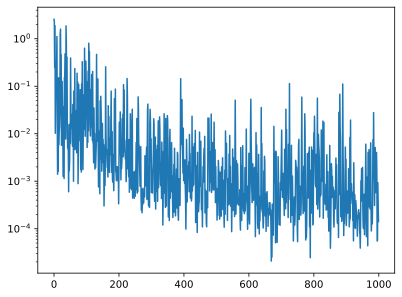

In [15]:
import copy

model_1 = FF()
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.01)
losses = []

ax_0 = plt.figure().add_subplot()

model_0 = copy.deepcopy(model_1)
xy = torch.rand((500,2))
z = f(xy[:,0], xy[:,1])
grad = torch.stack(f_diff(xy[:,0], xy[:,1])).T

for i in range(1000):
    epoch_loss = 0
    epochs = 1000
    for epoch in range(epochs):
        xy_with_grad = torch.asarray(xy, requires_grad=True)

        pred = model_1(xy_with_grad)
        # from chat-gpt:
        pred_gradients = torch.autograd.grad(outputs=pred, inputs=xy_with_grad, grad_outputs=torch.ones_like(pred), create_graph=True)[0]
        loss_1 = loss_fn(pred.flatten(), z)
        loss_2 = loss_fn(pred_gradients, grad)

        scale_factor = float(loss_1 / loss_2)

        # if abs(scale_factor) > 1.5:
        #     loss_2 = 0

        loss =  loss_1 #+ loss_2

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += float(loss)

    losses.append(epoch_loss / epochs)

    xy_new = torch.rand((1000,2))

    pred_model_0 = model_0(xy_new).detach()
    pred_model_1 = model_1(xy_new).detach()

    error = abs(pred_model_0 - pred_model_1).flatten()
    quantile = torch.quantile(error, 0.7)
    mask = (error >= quantile).flatten()
    # mask = error >= 0

    error_dist = (torch.exp(error[mask]) / torch.sum(torch.exp(error[mask])))

    sample_mask = error_dist.multinomial(10, replacement=False)

    z_new = f(xy_new[:,0], xy_new[:,1])
    xy = xy_new[mask][sample_mask]
    z = z_new[mask][sample_mask]
    grad = torch.stack(f_diff(xy[:,0], xy[:,1])).T
    model_0 = copy.deepcopy(model_1)

    # if i % 100 == 0:
    #     fig = plt.figure()
    #     ax_1 = fig.add_subplot(1,2,1,projection='3d')
    #     ax_1.scatter(xy[:,0], xy[:,1], color="red")
    #     ax_1.scatter(xy_new[:,0], xy_new[:,1], error, c=error)

    #     ax_2 = fig.add_subplot(1,2,2,projection='3d')
    #     ax_2.scatter(xy_new[:,0], xy_new[:,1], pred_model_1, c=pred_model_1)

ax_0.semilogy(losses)

Text(0.5, 0.92, 'Different')

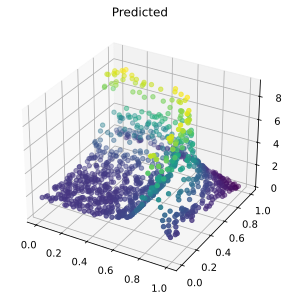

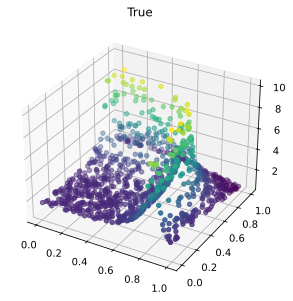

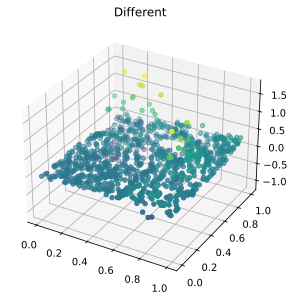

In [16]:
xy = torch.rand((1000,2))

z = f(xy[:,0], xy[:,1])
z_0 = model_0(xy).detach().flatten()
z_1 = model_1(xy).detach().flatten()

ax_0 = plt.figure().add_subplot(projection='3d')
ax_1 = plt.figure().add_subplot(projection='3d')
ax_2 = plt.figure().add_subplot(projection='3d')

ax_0.scatter(xy[:,0], xy[:,1], z_1, c=z_1)
ax_0.set_title("Predicted")

ax_1.scatter(xy[:,0], xy[:,1], z, c=z)
ax_1.set_title("True")

ax_2.scatter(xy[:,0], xy[:,1], z - z_1, c=z - z_1)
ax_2.set_title("Different")

### 2. Attempt

In [17]:
from sympy.utilities.lambdify import lambdify
x, y = sy.var("x y")

eq = (sy.sqrt((0.5 - x**4 - y**4)**2) + 0.1)**-1
eq_diff = [sy.diff(eq,x), sy.diff(eq,y)]

f = lambdify([x,y], eq)
f_diff = lambdify([x,y], eq_diff)

In [18]:
class FF(nn.Module):
    def __init__(self, hidden_size = 30) -> None:
        super().__init__()
        self.nn = nn.Sequential(
            nn.Linear(2,hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size,hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size,1),
        )
    
    def forward(self, x):
        return self.nn(x)

/Users/louiss/code/uni/master/SML/.venv/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


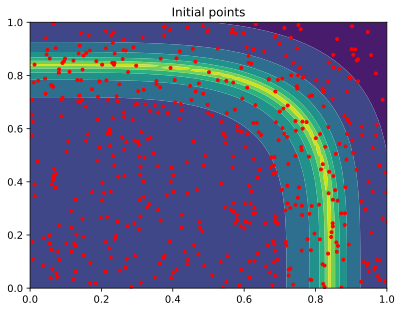

In [19]:
points = torch.rand((500, 2))
grid_x = torch.linspace(0,1,100)
grid_y = torch.linspace(0,1,100)

XS, YS = torch.meshgrid(grid_x, grid_y)
ZS_true = f(XS, YS)
xy = torch.column_stack((XS.flatten(), YS.flatten()))

plt.title("Initial points")

plt.contourf(XS, YS, ZS_true)
plt.plot(points[:,0], points[:,1], ".r")

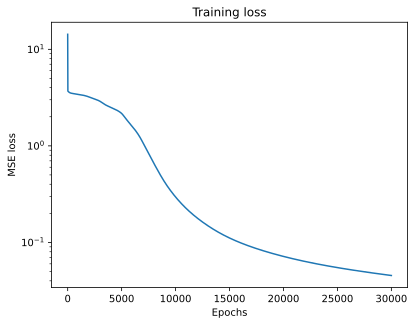

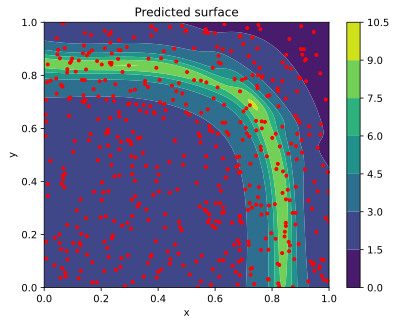

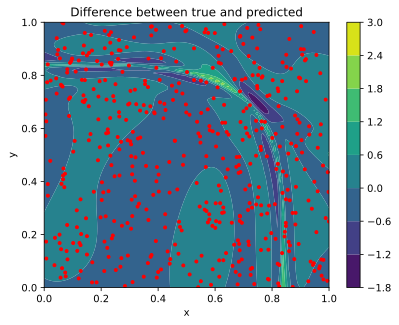

In [20]:
losses = []
errors = []

model = FF()
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)


for k in range(30_000):
    pred = model.forward(points)
    loss = loss_fn(pred.flatten(), f(points[:, 0], points[:, 1]))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses.append(loss.item())

    model.eval()
    new_model_eval_true = model.forward(xy).flatten()
    error_true = torch.mean(torch.abs(new_model_eval_true - ZS_true.flatten()))
    errors.append(error_true.item())
    model.train()


plt.figure()
plt.title("Training loss")
plt.xlabel("Epochs")
plt.ylabel("MSE loss")
plt.semilogy(losses)

plt.figure()
plt.title("Predicted surface")
plt.xlabel("x")
plt.ylabel("y")
ZS_model = model.forward(xy).reshape(XS.shape).detach()
plt.contourf(XS, YS, ZS_model)
plt.plot(points[:,0], points[:,1], ".r")
plt.colorbar()

plt.figure()
plt.title("Difference between true and predicted")
plt.xlabel("x")
plt.ylabel("y")
plt.contourf(XS, YS, ZS_true - ZS_model)
plt.plot(points[:,0], points[:,1], ".r")
plt.colorbar()

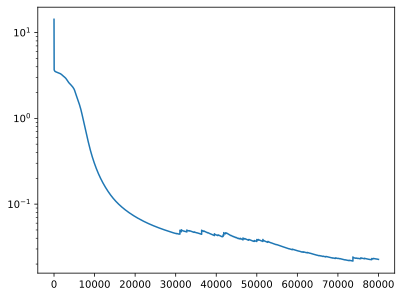

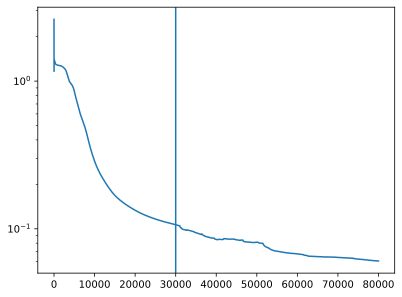

In [21]:
num_remove = 1
num_add = 1

epochs = 1000
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

for i in range(epochs):
    model.eval()

    eval_points = torch.as_tensor(np.random.uniform(0,1,(500,2)).astype(np.float32))

    old_model_eval = model.forward(eval_points).flatten()
    old_model_eval_true = model.forward(xy).flatten()
    model.train()

    for k in range(50):
        pred = model.forward(points)
        loss = loss_fn(pred.flatten(), f(points[:, 0], points[:, 1]))

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())

        with torch.no_grad():
            model.eval()
            new_model_eval = model.forward(eval_points).flatten()
            new_model_eval_true = model.forward(xy).flatten()
            model.train()

        error_true = torch.mean(torch.abs(new_model_eval_true - ZS_true.flatten()))
        errors.append(error_true.item())

    with torch.no_grad():
        model.eval()
        new_model_pred = model.forward(points).flatten()
        model.train()

    error_pred = torch.abs(new_model_pred - f(points[:, 0], points[:, 1]))
    error_eval = torch.abs(new_model_eval - old_model_eval)


    # errors.append(torch.mean(error_eval).item())

    # Remove
    _, error_pred_idx = torch.topk(error_pred, k=num_remove, largest=False)
    remove_mask = torch.ones(error_pred.shape[0], dtype=bool)
    remove_mask[error_pred_idx] = False

    points = points[remove_mask]

    # Add
    # _, error_eval_idx = torch.topk(error_eval, k=num_add, largest=True)
    softmax_dist = torch.exp(error_eval) / torch.sum(torch.exp(error_eval))
    error_eval_idx = softmax_dist.multinomial(num_samples=num_add, replacement=False)
    new_points = eval_points[error_eval_idx]
    points = torch.row_stack((points, new_points))

    # print(f"Loss: {loss.item()},\t Mean error: {errors[i]},\t Epoch: {i}")

    # if i % 100 == 0:
    #     ZS_model = model.forward(xy).reshape(XS.shape).detach()
    #     fig, axs = plt.subplots(1,2)
    #     fig.tight_layout()

    #     axs[0].set_title("Predicted surface")
    #     axs[0].set_xlabel("x")
    #     axs[0].set_ylabel("y")
    #     pcm_0 = axs[0].contourf(XS, YS, ZS_model)
    #     axs[0].plot(points[:,0], points[:,1], ".r")
    #     fig.colorbar(pcm_0, ax=axs[0])

    #     axs[1].set_title("Difference between true and predicted")
    #     axs[1].set_xlabel("x")
    #     axs[1].set_ylabel("y")
    #     pcm_1 = axs[1].contourf(XS, YS, ZS_true - ZS_model)
    #     axs[1].plot(points[:,0], points[:,1], ".r")

    #     fig.colorbar(pcm_1, ax=axs[1])

plt.figure()
plt.semilogy(losses)
plt.figure()
plt.semilogy(errors)
plt.axvline(30_000)

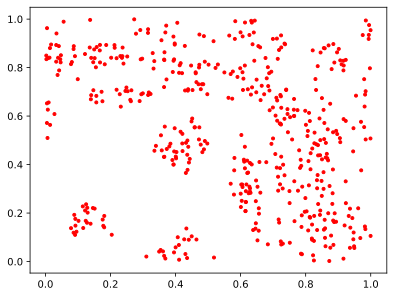

In [22]:
plt.plot(points[:,0], points[:,1], ".r")

Text(0.5, 0.92, 'Difference')

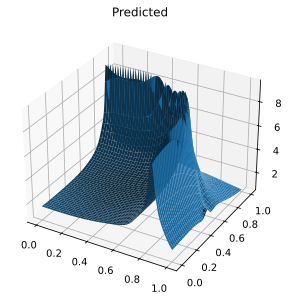

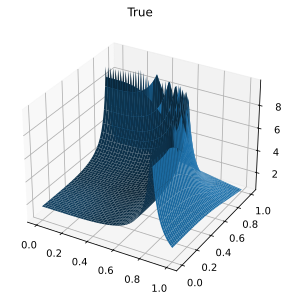

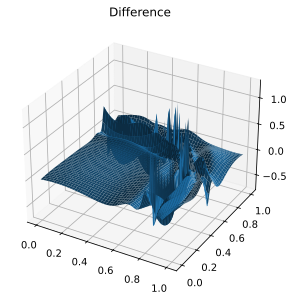

In [23]:
ax = plt.figure().add_subplot(projection='3d')
ZS_model = model.forward(xy).reshape(XS.shape).detach()
ax.plot_surface(XS, YS, ZS_model)
ax.set_title("Predicted")

ax = plt.figure().add_subplot(projection='3d')
ax.plot_surface(XS, YS, ZS_true)
ax.set_title("True")

ax = plt.figure().add_subplot(projection='3d')
ax.plot_surface(XS, YS, ZS_true - ZS_model)
ax.set_title("Difference")

### 3. Attempt

In [24]:
@torch.jit.script
def f(x):
    return (torch.abs(0.5 - x[:,0]**4 - x[:,1]**4) + 0.1)**(-1)

In [25]:
class FF(torch.jit.ScriptModule):
    def __init__(self, hidden_size = 30) -> None:
        super().__init__()
        self.nn = nn.Sequential(
            nn.Linear(2,hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size,hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size,1),
        )
    @torch.jit.script_method
    def forward(self, x):
        return self.nn(x)

In [26]:
epochs = 500
inner_training = 50
initial_training = 1_000
num_remove = 1
num_select = 5
num_add = 2

model = FF()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
points = torch.rand((500,2))
losses = []
errors = []

for j in range(initial_training):
    pred = model.forward(points)
    loss = loss_fn(pred.flatten(), f(points))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()


for i in range(epochs):
    new_points = torch.rand((12000,2))

    with torch.no_grad():
        model.eval()
        old_model_eval = model.forward(points).flatten()
        old_model_pred = model.forward(new_points).flatten()
        model.train()

    for j in range(inner_training):
        pred = model.forward(points)
        loss = loss_fn(pred.flatten(), f(points))

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    with torch.no_grad():
        model.eval()
        new_model_eval = model.forward(points).flatten()
        new_model_pred = model.forward(new_points).flatten()
        model.train()

    error_pred = torch.abs(new_model_pred - old_model_pred)
    error_eval = torch.abs(old_model_eval - new_model_eval)

    # Track learning

    losses.append(loss.item())
    errors.append(torch.mean(error_pred).item())

    # Remove points

    _, error_pred_idx = torch.topk(error_eval, k=num_remove, largest=False)
    remove_mask = torch.ones(error_eval.shape[0], dtype=bool)
    remove_mask[error_pred_idx] = False

    points = points[remove_mask]

    # Add points
    
    _, error_eval_idx = torch.topk(error_pred, k=num_select, largest=True)

    
    selected_points = new_points[error_eval_idx]
    # added_points = (selected_points[:,:,None] + torch.rand(num_add, num_add)[None]*0.0001).T.reshape(num_add*num_select,2)
    added_points = selected_points[:,:] # + torch.rand(num_add, num_add)[None]*0.0001).T.reshape(num_add*num_select,2)
    points = torch.row_stack((points, added_points))

    # print(f"Epoch {i}\t Points:{points.shape[0]}\t Loss: {loss.item()}\t Error: {errors[i]}")

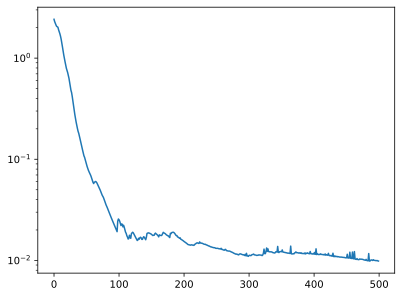

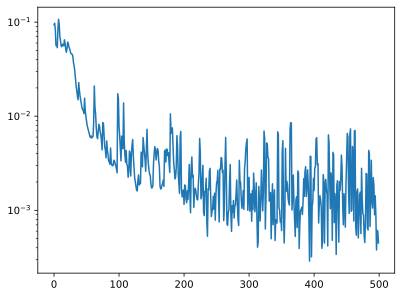

In [27]:
plt.figure()
plt.semilogy(losses)

plt.figure()
plt.semilogy(errors)

In [40]:
grid_x = torch.linspace(0,1,100)
grid_y = torch.linspace(0,1,100)
XS, YS = torch.meshgrid(grid_x, grid_y)
points_eval = torch.column_stack((XS.flatten(), YS.flatten()))
ZS =model.forward(points_eval).detach().reshape((100,100))

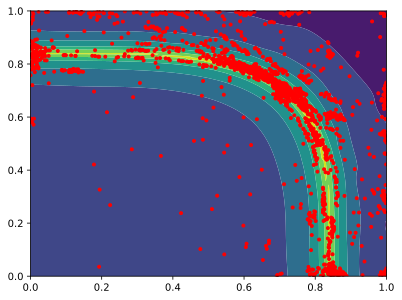

In [41]:
plt.contourf(XS, YS, ZS)
plt.plot(points[:,0], points[:,1], '.r')